In [39]:
import pypsa
import pandas as pd
import numpy as np

In [40]:
solver = "cbc"

*** 
Check-point 1:

**Build a network in PyPSA with two nodes (`bus`) and following components to build a simple green hydrogen production system:**

1. An `Electricity` bus with electricity as `carrier`.
   1. A wind generator inside this bus.
   2. A load_shedding generator inside this bus.
2. A `Hydrogen` bus with hydrogen as `carrier`.
   1. A hydrogen demand load inside this bus.
3. A electrolyser link to convert electricity into hydrogen.

**For simplicity, we assume the hydrogen demand profile to be flat for now. Afterwards, we want to supply electricy by attaching one renewable power plant implemented as (`generator`) (you have to call [`network.set_snapshots`](https://pypsa-readthedocs.readthedocs.io/en/readthedocs/api_reference.html?highlight=set_snapshots) to select a year). As help you should have a look at the [PyPSA documentation](https://pypsa-readthedocs.readthedocs.io/en/readthedocs/index.html) and the [minimal lopf example](https://www.pypsa.org/examples/minimal_example_lopf.html), understand what the [components documentation](https://pypsa-readthedocs.readthedocs.io/en/readthedocs/components.html) of PyPSA gives you and that you can find the underlying objective function and constraints in the [LOPF documentation](https://pypsa-readthedocs.readthedocs.io/en/readthedocs/optimal_power_flow.html).**


> **Remarks:** For time reasons, you do not have to build the network from scratch. However, to get you acquainted with PyPSA we have omitted a few elements or some of the parameters of the network marked by three question marks `???`. Either, you have to add an element similar to the one in the box above or add a few parameters.

#### Initialize network

In [41]:
# Create empty PyPSA network
network = pypsa.Network()

In [42]:
# Set snapshots to the year 2023 and at hourly resolution
snapshots = pd.date_range("01-01-2023", "01-01-2024", freq="H", inclusive="left")
network.set_snapshots(snapshots)

In [43]:
network.snapshots

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2023-12-31 14:00:00', '2023-12-31 15:00:00',
               '2023-12-31 16:00:00', '2023-12-31 17:00:00',
               '2023-12-31 18:00:00', '2023-12-31 19:00:00',
               '2023-12-31 20:00:00', '2023-12-31 21:00:00',
               '2023-12-31 22:00:00', '2023-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq='H')

In [44]:
# Import an example of wind daily pattern
wind_pattern = pd.read_csv("../data/weather data/example_onshore_wind_daily_pattern.csv")["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
wind_profile = pd.Series(list(wind_pattern)*365, index=network.snapshots)

<Axes: xlabel='snapshot'>

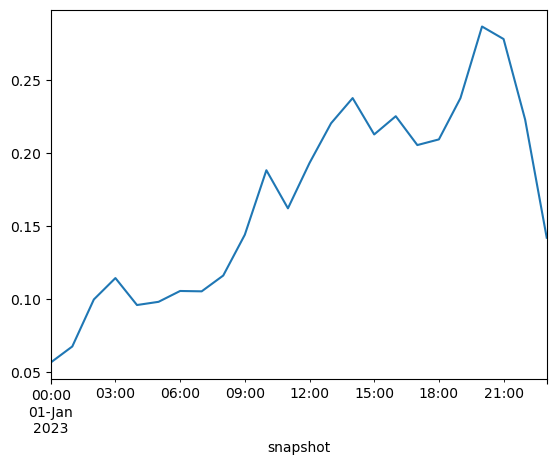

In [45]:
wind_profile.head(24).plot()

Add an `electricity` bus with electricity as `carrier`

In [46]:
network.add(class_name="Bus", name="electricity", carrier="electricity")

Add an `hydrogen` bus with hydrogen as `carrier`

In [47]:
network.add(class_name="Bus", name="hydrogen", carrier="hydrogen")

In [48]:
network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
electricity,1.0,,0.0,0.0,electricity,,1.0,0.0,inf,PQ,,
hydrogen,1.0,,0.0,0.0,hydrogen,,1.0,0.0,inf,PQ,,


Add constant hourly hydrogen load of `100MW` at the hydrogen bus. The name of the load can be `hydroge_load`

In [49]:
network.add(class_name="Load", name="hydrogen_load", bus="hydrogen", p_set=100)

In [50]:
network.loads

attribute,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
hydrogen_load,hydrogen,,,100.0,0.0,-1.0


Add a wind generator at the electricity bus with a initial capacity of `100MW`, maximum capacity of `500MW`, and marginal cost of `0$/MWh` into the network? The name of the generator can be `onshore_wind`. 

In [51]:
network.add(
      class_name="Generator", 
      name="onshore_wind",
      bus="electricity",
      carrier="electricity",
      p_nom_extendable=True,
      p_nom=100, # MW
      p_nom_max=500, # MW
      marginal_cost=0, #$/MWh
      p_max_pu=wind_profile
)

Add a electrolyser link, representing the electrolysis conversion with initial capacity of `20MW`, based on provided CAPEX, FOM, VOM, efficiency, interest rate and lifetime.

> **Source:** all costs for the example are taken from PyPSA"s technology database (https://github.com/PyPSA/technology-data) and the assumptions in year 2023 in EU map of hydrogen production costs (https://public.flourish.studio/visualisation/16659363/), with exchange rate of `1.1USD/EUR`

In [52]:
# Electrolyser's techno-economic parameters are given as:
eur_to_use = 1.1
lifetime = 10
interest = 0.05

CAPEX = 1590*eur_to_use # $/MW
FOM = 32*eur_to_use  # $/MW fixed
VOM = 0 # $/MWh variable
efficiency = 0.65

In [53]:
# We need to calculate annualized capital expenditure
def calculate_annualised_capex(capex: float, interest: float, lifetime: int):
    crf = (
        interest * (1 + interest) ** lifetime / ((1 + interest) ** lifetime - 1)
    )  # Capital recovery factor
    return capex * crf

In [54]:
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

network.add(
    class_name="Link",
    name="electrolyser",
    bus0="electricity",
    bus1="hydrogen",
    p_nom_extendable=True,
    p_nom=20,
    capital_cost=annualized_capex + FOM, #$/MW
    marginal_cost=VOM + water_cost, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime
)

Now try to solve your network

In [55]:
# Solve network using cbc solver
network.optimize(pyomo=False, solver_name="cbc")

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 111.45it/s]
INFO:linopy.io: Writing time: 0.33s
INFO:linopy.solvers:Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Sep  3 2024 

command line - cbc -printingOptions all -import /tmp/linopy-problem-qf6kcopv.lp -pyomo False -solve -solu /tmp/linopy-solve-219e78o3.sol (default strategy 1)
Option for printingOptions changed from normal to all
No match for pyomo - ? for list of commands
No match for False - ? for list of commands
Presolve determined that the problem was infeasible with tolerance of 1e-08
Analysis indicates model infeasible or unbounded
1 infeasibilities
Analysis indicates model infeasible or unbounded
Perturbing problem by 0.001% of 261.7035 - largest nonzero change 0 ( 0%) - largest zero change 0
0  Obj -5234.07 Primal inf 1347692.3 (8760) Dual inf 89.190076 (87

('warning', 'infeasible')

Lets look at the optimisation. Does it solve successfully?

Add a load shedding generator at the electricity bus with marginal cost of `9999$/MWh` (or any large figures) into the network? The name of the generator can be `load_shedding`. 

In [56]:
# generator for electricity production from load shedding
network.add(
    class_name="Generator",
    name="load_shedding",
    bus="electricity",
    carrier="electricity",
    p_nom_extendable=True,
    marginal_cost=9999,
    )

Now retry to solve your network. Does it solve successfully?

In [57]:
# Solve network using cbc solver
network.optimize(pyomo=False, solver_name="cbc")

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 106.66it/s]
INFO:linopy.io: Writing time: 0.36s
INFO:linopy.solvers:Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Sep  3 2024 

command line - cbc -printingOptions all -import /tmp/linopy-problem-tqu8xud2.lp -pyomo False -solve -solu /tmp/linopy-solve-8pjiv906.sol (default strategy 1)
Option for printingOptions changed from normal to all
No match for pyomo - ? for list of commands
No match for False - ? for list of commands
Presolve 0 (-70084) rows, 0 (-26284) columns and 0 (-113884) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 6.1403648e+09
After Postsolve, objective 6.1403648e+09, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 6140364811 - 0 iterations time 0.052, Presolve 0.05
Total time (CPU seconds):       2.67   (Wa

('ok', 'optimal')

Lets look at some results! Back to read the docs. How would you look at results?

<Axes: xlabel='snapshot'>

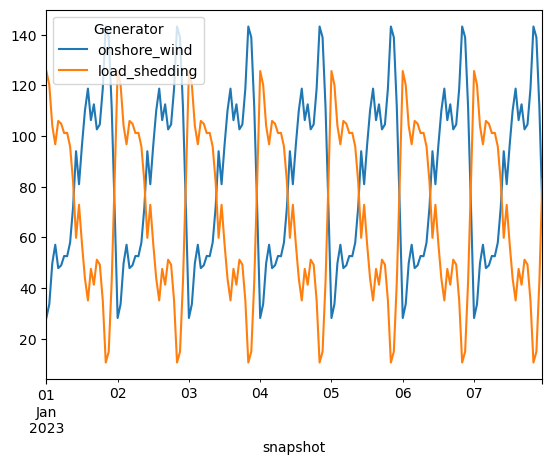

In [58]:
network.generators_t.p[:24*7].plot()

In [59]:
network.links_t.p0.head()

Link,electrolyser
snapshot,
2023-01-01 00:00:00,153.84615
2023-01-01 01:00:00,153.84615
2023-01-01 02:00:00,153.84615
2023-01-01 03:00:00,153.84615
2023-01-01 04:00:00,153.84615


In [60]:
network.links_t.p1.head()

Link,electrolyser
snapshot,
2023-01-01 00:00:00,-99.999998
2023-01-01 01:00:00,-99.999998
2023-01-01 02:00:00,-99.999998
2023-01-01 03:00:00,-99.999998
2023-01-01 04:00:00,-99.999998


In [61]:
network.loads_t.p.head()

Load,hydrogen_load
snapshot,
2023-01-01 00:00:00,100.0
2023-01-01 01:00:00,100.0
2023-01-01 02:00:00,100.0
2023-01-01 03:00:00,100.0
2023-01-01 04:00:00,100.0


Ending of check-point 1 - export network

In [62]:
# Export network
network.export_to_netcdf("../results/network_d2_e1-1.nc")

INFO:pypsa.io:Exported network network_d2_e1-1.nc has loads, buses, generators, links


<xarray.Dataset> Size: 1MB
Dimensions:                       (snapshots: 8760, investment_periods: 0,
                                   loads_i: 1, loads_t_p_i: 1, buses_i: 2,
                                   buses_t_p_i: 2, buses_t_marginal_price_i: 2,
                                   generators_i: 2, generators_t_p_max_pu_i: 1,
                                   generators_t_p_i: 2, links_i: 1,
                                   links_t_p0_i: 1, links_t_p1_i: 1)
Coordinates: (12/13)
  * snapshots                     (snapshots) int64 70kB 0 1 2 ... 8758 8759
  * investment_periods            (investment_periods) int64 0B 
  * loads_i                       (loads_i) object 8B 'hydrogen_load'
  * loads_t_p_i                   (loads_t_p_i) object 8B 'hydrogen_load'
  * buses_i                       (buses_i) object 16B 'electricity' 'hydrogen'
  * buses_t_p_i                   (buses_t_p_i) object 16B 'electricity' 'hyd...
    ...                            ...
  * generators_i                  (generators_i) object 16B 'onshore_wind' 'l...
  * generators_t_p_max_pu_i       (generators_t_p_max_pu_i) object 8B 'onshor...
  * generators_t_p_i              (generators_t_p_i) object 16B 'onshore_wind...
  * links_i                       (links_i) object 8B 'electrolyser'
  * links_t_p0_i                  (links_t_p0_i) object 8B 'electrolyser'
  * links_t_p1_i                  (links_t_p1_i) object 8B 'electrolyser'
Data variables: (12/33)
    snapshots_snapshot            (snapshots) datetime64[ns] 70kB 2023-01-01 ...
    snapshots_objective           (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_stores              (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_generators          (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    investment_periods_objective  (investment_periods) object 0B 
    investment_periods_years      (investment_periods) object 0B 
    ...                            ...
    links_p_nom_extendable        (links_i) bool 1B True
    links_capital_cost            (links_i) float64 8B 261.7
    links_marginal_cost           (links_i) float64 8B 1.248
    links_p_nom_opt               (links_i) float64 8B 153.8
    links_t_p0                    (snapshots, links_t_p0_i) float64 70kB 153....
    links_t_p1                    (snapshots, links_t_p1_i) float64 70kB -100...
Attributes:
    network__linearized_uc:      0
    network__multi_invest:       0
    network_name:                
    network_objective:           6140364811.121965
    network_objective_constant:  5234.070032291674
    network_pypsa_version:       0.28.0
    network_srid:                4326
    crs:                         {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Worl...
    meta:                        {}

***
Check-point 2:

**Add a solar generator so that we will have two generators + one load-shedding generator in the system**

In [63]:
# Import check-point 1 network
network = pypsa.Network("../results/network_d2_e1-1.nc")

INFO:pypsa.io:Imported network network_d2_e1-1.nc has buses, generators, links, loads


In [64]:
# Import an example of solar daily pattern
solar_pattern = pd.read_csv("../data/weather data/example_solar_daily_pattern.csv")["daily pattern"]
# annual time-series availability of solar (just a simplified example)
solar_profile = pd.Series(list(solar_pattern)*365, index=network.snapshots)

<Axes: xlabel='snapshot'>

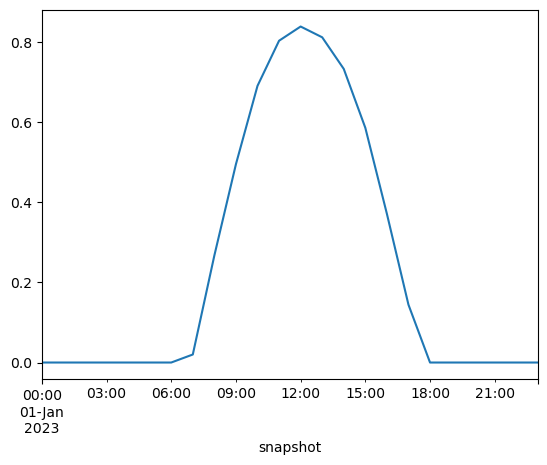

In [65]:
solar_profile.head(24).plot()

Add a solar generator at the electricity bus with a initial capacity of `50MW`, maximum capacity of `500MW`, and marginal cost of `0$/MWh` into the network? The name of the generator can be `solar`. 

In [66]:
network.add(
      class_name="Generator", 
      name="solar",
      bus="electricity",
      carrier="electricity",
      p_nom_extendable=True,
      p_nom=50,
      p_nom_max=500, # MW
      marginal_cost=0, #$/MWh
      p_max_pu=solar_profile
)

In [67]:
network.generators

,bus,p_nom,p_nom_extendable,p_nom_max,carrier,marginal_cost,p_nom_opt,control,type,p_nom_mod,...,stand_by_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight
Generator,,,,,,,,,,,,,,,,,,,,,
onshore_wind,electricity,100.0,True,500.0,electricity,0.0,500.00000,PQ,,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0
load_shedding,electricity,0.0,True,inf,electricity,9999.0,125.65864,PQ,,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0
solar,electricity,50.0,True,500.0,electricity,0.0,0.00000,PQ,,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,1.0


Ending of check-point 2 - Solve network, analyse results and export network

In [68]:
# Solve network using cbc solver
network.optimize(pyomo=False, solver_name="cbc")

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 86.83it/s]
INFO:linopy.io: Writing time: 0.47s
INFO:linopy.solvers:Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Sep  3 2024 

command line - cbc -printingOptions all -import /tmp/linopy-problem-4p36ugtg.lp -pyomo False -solve -solu /tmp/linopy-solve-xsxj18y4.sol (default strategy 1)
Option for printingOptions changed from normal to all
No match for pyomo - ? for list of commands
No match for False - ? for list of commands
Presolve 0 (-87606) rows, 0 (-35045) columns and 0 (-144181) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 3.9624172e+09
After Postsolve, objective 3.9624172e+09, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 3962417187 - 0 iterations time 0.092, Presolve 0.09
Total time (CPU seconds):       2.29   (Wal

('ok', 'optimal')

In [69]:
network.generators['p_nom_opt']

Generator
onshore_wind     500.00000
load_shedding    125.65864
solar            500.00000
Name: p_nom_opt, dtype: float64

<Axes: xlabel='snapshot'>

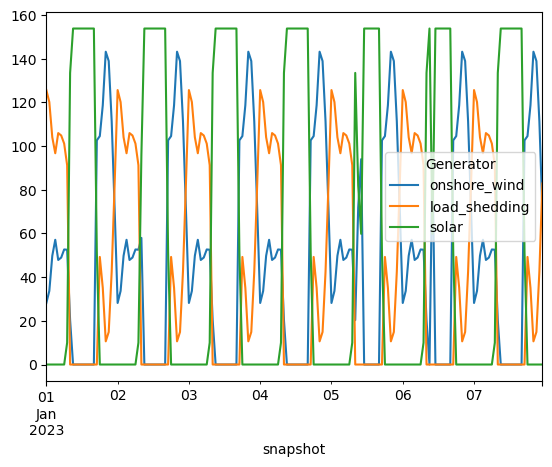

In [70]:
# Inspect the interaction of different power plants to supply loads
network.generators_t.p[:24*7].plot()

<Axes: xlabel='snapshot'>

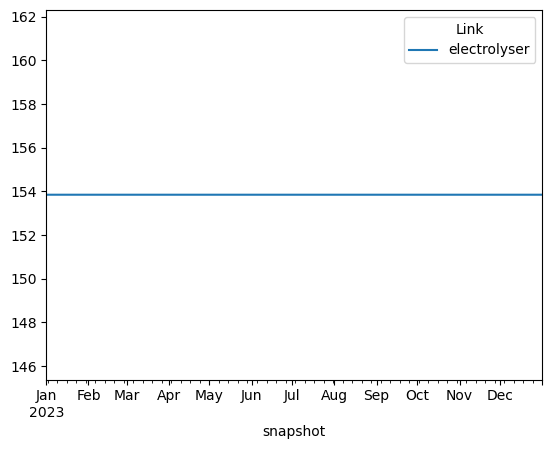

In [71]:
# Inspect the electrolysis conversion
network.links_t.p0.plot()

In [72]:
# Exporting check-point 2 network
network.export_to_netcdf("../results/network_d2_e1-2.nc")

INFO:pypsa.io:Exported network network_d2_e1-2.nc has loads, buses, generators, links


<xarray.Dataset> Size: 1MB
Dimensions:                       (snapshots: 8760, investment_periods: 0,
                                   loads_i: 1, loads_t_p_i: 1, buses_i: 2,
                                   buses_t_p_i: 2, buses_t_marginal_price_i: 2,
                                   generators_i: 3, generators_t_p_max_pu_i: 2,
                                   generators_t_p_i: 3, links_i: 1,
                                   links_t_p0_i: 1, links_t_p1_i: 1)
Coordinates: (12/13)
  * snapshots                     (snapshots) int64 70kB 0 1 2 ... 8758 8759
  * investment_periods            (investment_periods) int64 0B 
  * loads_i                       (loads_i) object 8B 'hydrogen_load'
  * loads_t_p_i                   (loads_t_p_i) object 8B 'hydrogen_load'
  * buses_i                       (buses_i) object 16B 'electricity' 'hydrogen'
  * buses_t_p_i                   (buses_t_p_i) object 16B 'electricity' 'hyd...
    ...                            ...
  * generators_i                  (generators_i) object 24B 'onshore_wind' .....
  * generators_t_p_max_pu_i       (generators_t_p_max_pu_i) object 16B 'onsho...
  * generators_t_p_i              (generators_t_p_i) object 24B 'onshore_wind...
  * links_i                       (links_i) object 8B 'electrolyser'
  * links_t_p0_i                  (links_t_p0_i) object 8B 'electrolyser'
  * links_t_p1_i                  (links_t_p1_i) object 8B 'electrolyser'
Data variables: (12/33)
    snapshots_snapshot            (snapshots) datetime64[ns] 70kB 2023-01-01 ...
    snapshots_objective           (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_generators          (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_stores              (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    investment_periods_objective  (investment_periods) float64 0B 
    investment_periods_years      (investment_periods) float64 0B 
    ...                            ...
    links_p_nom_extendable        (links_i) bool 1B True
    links_capital_cost            (links_i) float64 8B 261.7
    links_marginal_cost           (links_i) float64 8B 1.248
    links_p_nom_opt               (links_i) float64 8B 153.8
    links_t_p0                    (snapshots, links_t_p0_i) float64 70kB 153....
    links_t_p1                    (snapshots, links_t_p1_i) float64 70kB -100...
Attributes:
    network__linearized_uc:      0
    network__multi_invest:       0
    network_name:                
    network_objective:           3962417187.0603395
    network_objective_constant:  5234.070032291674
    network_pypsa_version:       0.28.0
    network_srid:                4326
    crs:                         {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Worl...
    meta:                        {}